# Intent Detection with Audio Classification

### DSL Final Project (Jan 2023)

#### Owners: Sepehr Alemzadeh (314315), Afsoon Abbasi (314427)

In this project, we work on an intent detection problem given an audio sample. The goal is to predict both the action requested and the object that is affected by the action. The dataset consists of audio files in WAV format and several attributes such as speakerId, action, object, fluency level, first language spoken, current language used, gender, and age range. We will parse the data into spectogram and use deep learning techniques to read and train a Convolutional Neural Networks model. Our experiments show that a VGG-16 model gives the highest accuracy among all the trained models. 

## Import Required Packages

We begin with importing the required libraries for this implementation. It is notable that in this project we use PyTorch for the deep learning model.

In [89]:
# First we import the required packages for reading and preprocessing
# the data and also for visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import librosa
import librosa.display
from scipy.io import wavfile

# ----------------------------------------------------------------------------- #

# The determination whether to issue a warning message is controlled by 
# the warning filter which is a sequence of matching rules and actions.
# Rules can be added to the filter by calling filterwarnings()

import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------------------------------------------- #

# Import the required PyTorch libraries

# The torchvision package consists of popular datasets, model architectures,
# and common image transformations for computer vision. For more information
# see: https://pytorch.org/vision/stable/index.html

import torchvision 

# The torchaudio package is a library for audio and signal processing with
# PyTorch. It provides I/O, signal and data processing functions, datasets, 
# models implementations and application components. For more information
# please see: https://pytorch.org/audio/stable/index.html

import torchaudio

# The torch.utils.data package is a library for data loading, handling, and
# preprocessing. At the heart of PyTorch data loading utility is the library
# torch.utils.data.DataLoader class. It represents a Python iterable over a
# dataset. For more info see: https://pytorch.org/docs/stable/data.html#

from torch.utils.data import DataLoader, random_split, Dataset

# ----------------------------------------------------------------------------- #

# Additional packages for data handling, model and training

# We use the dataloader class to obtain the wavefor and output labels given
# audio signals. This class uses torch library Dataset to do this.

from dataloader import *

# We use the dataset class to load data from the source, trim the data length
# to get consistent audio duration throughout training, determine the waveform
# and labels, and convert data into torch's tensor data type for model training
# and testing

from dataset import ProjectAudioCommandDataset

# The package train_utils is where we define the train and test methods in the
# training and validation phase. The overall learning is via a backpropagation
# scheme for different neural networks models

from train_utils import *

# We train different models and compare the final results. The model package
# includes all those models

from model import *

## Audio Files Durations

For our model, we need to have transformed audio files with consistent durations. We take a look at the histogram that consists of all files durations to get a better understanding of the data files.

In [90]:
%%time

dur_list = []
data = pd.read_csv("./dsl_data/development.csv", index_col=None)

for x in data['path']:
    sample_rate, waveform = wavfile.read(x)
    duration = len(waveform) / sample_rate
    dur_list.append(duration)

Wall time: 2min 17s


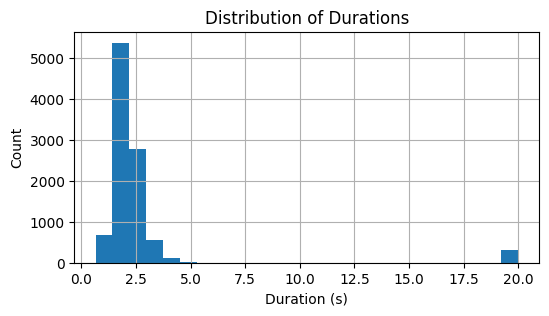

In [91]:
mpl.rcParams['figure.figsize'] = (6, 3)
mpl.rcParams['font.size'] = 10

plt.hist(dur_list, bins=25)
plt.title('Distribution of Durations')
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.grid()
plt.show()

## Define Train/Test Sets

We use the ProjectAudioCommandDataset class from the dataset package to import train and test dataset in the form of torch tensors. We keep 10% of the given data set for validation on each epoch of the training.

In [93]:
train_set = ProjectAudioCommandDataset(subset="training")
test_set = ProjectAudioCommandDataset(subset="testing")

In [94]:
# The length of each imported dataset should be equivalent to the given
# development.csv and evaluation.csv files in the project dataset

print("Length of dataset for training phase: {}".format(len(train_set)))
print("Length of dataset for testing phase: {}".format(len(test_set)))

Length of dataset for training phase: 9854
Length of dataset for testing phase: 1455


## Insights on the Audio WAV Files

In [95]:
# Choose the first audio file in the training set
waveform, sample_rate, label, speaker_id = train_set[0]

In [96]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
print("The label of the data: {}".format(label))

Shape of waveform: torch.Size([1, 80000])
Sample rate of waveform: 16000
The label of the data: change language


#### Listen to the sampled audio file

In [97]:
import IPython

wav_file = './dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-11e9-a9a5-5dbec3b8816a.wav'
IPython.display.Audio(wav_file)

#### Representation of the Recording in Time-Domain

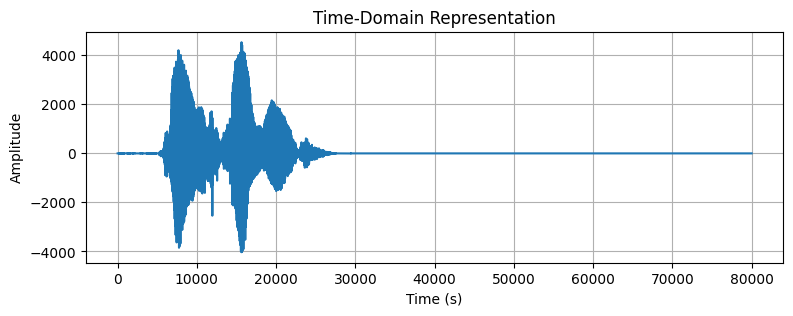

In [103]:
mpl.rcParams['figure.figsize'] = (9, 3)

plt.plot(list(waveform[0]))
plt.title('Time-Domain Representation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

#### Representation in the Frequency-Domain 

Finding the signal in frequency domain

In [10]:
# Use fft to convert time to frequency
from numpy.fft import fft

freq_sample = fft(waveform)[0:(sample_rate//2)]

N = len(freq_sample[0])
n = np.arange(N)
T = N / sample_rate
freq = n / T 

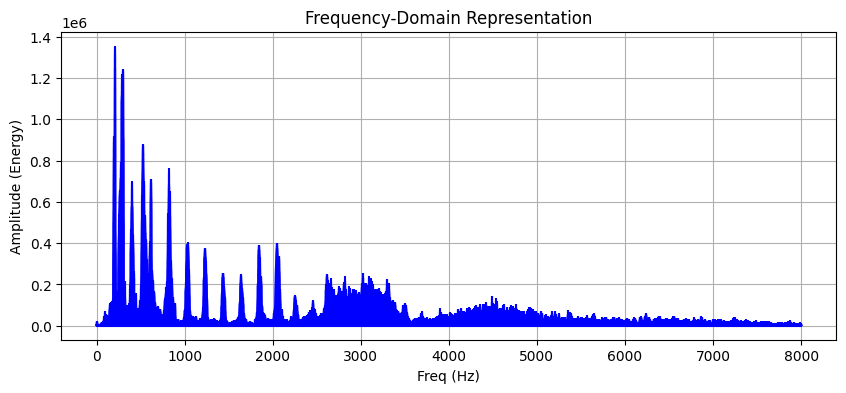

In [49]:
mpl.rcParams['figure.figsize'] = (10, 4)

plt.stem(freq[:N//2], np.abs(freq_sample[0])[:N//2], 'b', markerfmt = " ", basefmt = "-b")
plt.title('Frequency-Domain Representation')
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude (Energy)')
plt.grid()
plt.show()

#### Mel-Spectogram Plot

Finding the spectogram matrix to take advantage of both time and frequency domains

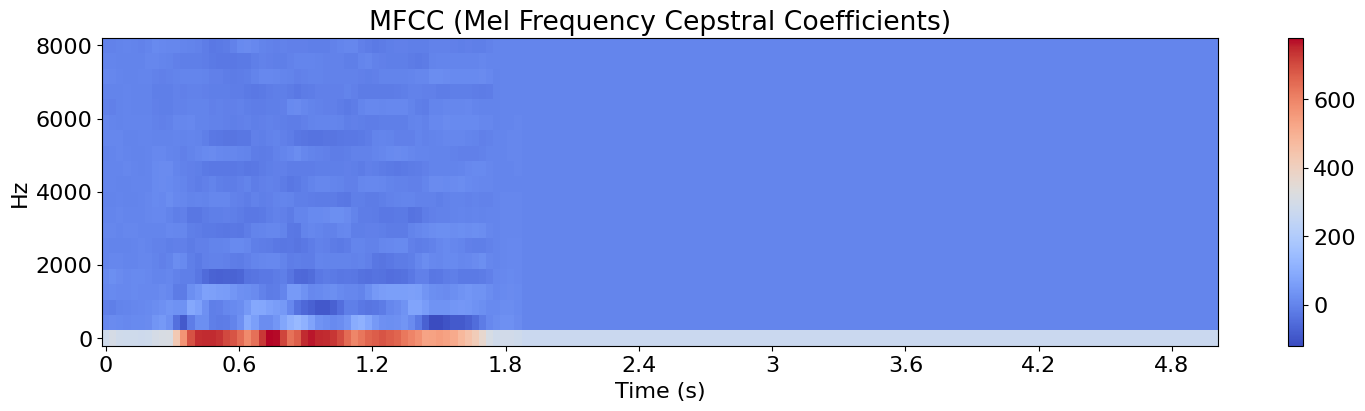

In [12]:
# We use the Python librosa package to find the mfcc 2d signal
mfcc_signal = librosa.feature.mfcc(y=train_set[0][0].squeeze().numpy(), sr=sample_rate, n_mfcc=20)

plt.figure(figsize=(18, 4))
mpl.rcParams['font.size'] = 16

librosa.display.specshow(mfcc_signal.squeeze(), sr=sample_rate, x_axis='time', y_axis='hz')
plt.xlabel('Time (s)')
plt.ylabel('Hz')
plt.title('MFCC (Mel Frequency Cepstral Coefficients)')
plt.colorbar()
plt.show()

## Define Features and Labels for Training

We extract the wave signals and output labels into two distinct python lists for training. To this end, we need to make sure the length of the waveforms are consistent, hence filter out data based on common length of 80000 elements.

In [13]:
%%time

wave = []
labels = []
for i in range(0, len(train_set)):
    if train_set[i][0].size(1) == 80000:
        wave.append(train_set[i][0])
        labels.append(train_set[i][2])

Wall time: 3min 5s


#### Define Classification Labels

In [14]:
labels_dict = train_set.classes
labels_dict

['change language',
 'activatemusic',
 'deactivatelights',
 'increasevolume',
 'decreasevolume',
 'increaseheat',
 'decreaseheat']

#### Choose Training Model

At this point, we are well-equipped to pick the training model followed by the integration of data for training epochs.

In [79]:
# Choose the data transformation type here and the employed model
transform_type = 3

if transform_type == 1:
    print("No Data Transformation - Simple 1d Audio Analysis")
    train_audio_transforms = None
    net = NN(num_class=len(labels_dict))
    results_txt = 'waveform'
    model_name = 'NN'
    
elif transform_type == 2:
    print("MFCC Features Classification")
    train_audio_transforms = nn.Sequential(
        torchaudio.transforms.MFCC(log_mels=False)
    )
    net = NN2D(num_class=len(labels_dict))
    results_txt = 'MFCC'
    model_name = 'NN2D'
    
else:
    print("MFCC with VGG16 Model")
    train_audio_transforms = nn.Sequential(
        torchaudio.transforms.MFCC(log_mels=False),
    )
    net = VGG16(num_classes=len(labels_dict))
    results_txt = 'MFCC_VGG16'
    model_name = 'VGG16'

MFCC with VGG16 Model


#### Prepare Train/Test Data

In [80]:
# Define dataset
dataset = SpeechDataLoader(wave, labels, labels_dict, train_audio_transforms)

# Split data into train/test
traindata, testdata = random_split(dataset, [round(len(dataset) * .9), round(len(dataset) * .1)])

# Putting train data into torch DataLoader format
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Putting test data into torch DataLoader format
valloader = torch.utils.data.DataLoader(testdata, batch_size=32, shuffle=True)

#### Model Spec and Hyperparameters

In [81]:
# We prefer GPU to run 2d CNNs, but if the device does not have GPU, we choose CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = net.to(device)

In [82]:
# Choose number of epochs
num_epochs = 100

# Choose loss function
criterion = nn.CrossEntropyLoss()

# Choose optimization technique
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Set the learning rate according to the 1cycle learning rate policy
# See here: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(trainloader)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

#### Model Training

#### Model 1

In [55]:
val_acc = []
val_loss = []

for epoch in range(0, num_epochs):
    train(net, trainloader, optimizer, scheduler, criterion, epoch, device)
    best_acc = validation(net, valloader, criterion, epoch, device, results_txt, model_name, val_acc, val_loss)

Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:06<00:00,  1.02s/it]


Epoch: [1]  loss: [6.89] Accuracy [19.16] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.47it/s]



Validation Epoch #1			Loss: 1.9192 Acc@1: 23.66%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [04:57<00:00,  1.00it/s]


Epoch: [2]  loss: [2.05] Accuracy [24.37] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.70it/s]



Validation Epoch #2			Loss: 1.9075 Acc@1: 23.98%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:04<00:00,  1.02s/it]


Epoch: [3]  loss: [2.04] Accuracy [24.60] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.56it/s]



Validation Epoch #3			Loss: 1.8978 Acc@1: 22.93%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [04:59<00:00,  1.00s/it]


Epoch: [4]  loss: [1.93] Accuracy [24.46] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.66it/s]



Validation Epoch #4			Loss: 1.8864 Acc@1: 22.62%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:26<00:00,  1.09s/it]


Epoch: [5]  loss: [1.89] Accuracy [24.39] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.60it/s]



Validation Epoch #5			Loss: 1.8669 Acc@1: 23.87%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:42<00:00,  1.14s/it]


Epoch: [6]  loss: [1.88] Accuracy [24.59] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.33it/s]



Validation Epoch #6			Loss: 1.8564 Acc@1: 23.25%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:31<00:00,  1.11s/it]


Epoch: [7]  loss: [1.86] Accuracy [25.29] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.65it/s]



Validation Epoch #7			Loss: 1.8450 Acc@1: 24.71%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:17<00:00,  1.06s/it]


Epoch: [8]  loss: [1.85] Accuracy [25.48] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.65it/s]



Validation Epoch #8			Loss: 1.8377 Acc@1: 25.45%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:10<00:00,  1.04s/it]


Epoch: [9]  loss: [1.83] Accuracy [25.58] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.75it/s]



Validation Epoch #9			Loss: 1.8353 Acc@1: 26.81%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:09<00:00,  1.04s/it]


Epoch: [10]  loss: [1.82] Accuracy [26.82] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.65it/s]



Validation Epoch #10			Loss: 1.8305 Acc@1: 27.64%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:12<00:00,  1.05s/it]


Epoch: [11]  loss: [1.81] Accuracy [26.21] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.56it/s]



Validation Epoch #11			Loss: 1.8485 Acc@1: 27.02%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:17<00:00,  1.06s/it]


Epoch: [12]  loss: [1.81] Accuracy [27.15] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.65it/s]



Validation Epoch #12			Loss: 1.8344 Acc@1: 27.02%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:25<00:00,  1.09s/it]


Epoch: [13]  loss: [1.80] Accuracy [27.04] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.56it/s]



Validation Epoch #13			Loss: 1.8388 Acc@1: 27.12%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:23<00:00,  1.08s/it]


Epoch: [14]  loss: [1.80] Accuracy [27.21] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.75it/s]



Validation Epoch #14			Loss: 1.8286 Acc@1: 27.33%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:27<00:00,  1.10s/it]


Epoch: [15]  loss: [1.74] Accuracy [29.23] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.64it/s]



Validation Epoch #15			Loss: 1.7913 Acc@1: 24.50%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:28<00:00,  1.10s/it]


Epoch: [16]  loss: [1.67] Accuracy [30.94] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.67it/s]



Validation Epoch #16			Loss: 1.6495 Acc@1: 33.09%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:30<00:00,  1.11s/it]


Epoch: [17]  loss: [1.64] Accuracy [31.49] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.60it/s]



Validation Epoch #17			Loss: 1.7319 Acc@1: 29.63%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:33<00:00,  1.11s/it]


Epoch: [18]  loss: [1.61] Accuracy [32.58] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.65it/s]



Validation Epoch #18			Loss: 1.6115 Acc@1: 35.92%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:32<00:00,  1.11s/it]


Epoch: [19]  loss: [1.60] Accuracy [33.24] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.67it/s]



Validation Epoch #19			Loss: 1.6130 Acc@1: 33.61%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:33<00:00,  1.12s/it]


Epoch: [20]  loss: [1.57] Accuracy [34.22] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.69it/s]



Validation Epoch #20			Loss: 1.5431 Acc@1: 36.23%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:35<00:00,  1.12s/it]


Epoch: [21]  loss: [1.56] Accuracy [33.90] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.67it/s]



Validation Epoch #21			Loss: 1.5535 Acc@1: 36.65%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:35<00:00,  1.12s/it]


Epoch: [22]  loss: [1.55] Accuracy [35.11] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.62it/s]



Validation Epoch #22			Loss: 1.6289 Acc@1: 35.92%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:33<00:00,  1.11s/it]


Epoch: [23]  loss: [1.55] Accuracy [35.24] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.70it/s]



Validation Epoch #23			Loss: 1.5456 Acc@1: 37.38%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:33<00:00,  1.11s/it]


Epoch: [24]  loss: [1.53] Accuracy [35.25] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.58it/s]



Validation Epoch #24			Loss: 1.5858 Acc@1: 36.75%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:33<00:00,  1.12s/it]


Epoch: [25]  loss: [1.52] Accuracy [36.41] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.57it/s]



Validation Epoch #25			Loss: 1.4822 Acc@1: 38.32%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:32<00:00,  1.11s/it]


Epoch: [26]  loss: [1.51] Accuracy [36.82] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.67it/s]



Validation Epoch #26			Loss: 1.4889 Acc@1: 38.12%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:32<00:00,  1.11s/it]


Epoch: [27]  loss: [1.50] Accuracy [37.75] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.69it/s]



Validation Epoch #27			Loss: 1.4771 Acc@1: 37.59%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:31<00:00,  1.11s/it]


Epoch: [28]  loss: [1.49] Accuracy [37.48] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.70it/s]



Validation Epoch #28			Loss: 1.4687 Acc@1: 43.04%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:31<00:00,  1.11s/it]


Epoch: [29]  loss: [1.47] Accuracy [38.80] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.64it/s]



Validation Epoch #29			Loss: 1.4516 Acc@1: 42.20%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:33<00:00,  1.11s/it]


Epoch: [30]  loss: [1.46] Accuracy [40.11] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.69it/s]



Validation Epoch #30			Loss: 1.4055 Acc@1: 42.20%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:34<00:00,  1.12s/it]


Epoch: [31]  loss: [1.46] Accuracy [40.10] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.60it/s]



Validation Epoch #31			Loss: 1.3787 Acc@1: 40.42%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:34<00:00,  1.12s/it]


Epoch: [32]  loss: [1.43] Accuracy [41.84] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.59it/s]



Validation Epoch #32			Loss: 1.3600 Acc@1: 45.76%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:34<00:00,  1.12s/it]


Epoch: [33]  loss: [1.41] Accuracy [42.35] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.71it/s]



Validation Epoch #33			Loss: 1.3507 Acc@1: 46.91%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:32<00:00,  1.11s/it]


Epoch: [34]  loss: [1.41] Accuracy [41.60] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.67it/s]



Validation Epoch #34			Loss: 1.3349 Acc@1: 44.40%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:43<00:00,  1.15s/it]


Epoch: [35]  loss: [1.37] Accuracy [42.87] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.50it/s]



Validation Epoch #35			Loss: 1.3626 Acc@1: 45.45%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:46<00:00,  1.16s/it]


Epoch: [36]  loss: [1.35] Accuracy [43.29] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.63it/s]



Validation Epoch #36			Loss: 1.2302 Acc@1: 50.05%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:33<00:00,  1.11s/it]


Epoch: [37]  loss: [1.33] Accuracy [44.95] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.77it/s]



Validation Epoch #37			Loss: 1.2470 Acc@1: 50.05%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:33<00:00,  1.12s/it]


Epoch: [38]  loss: [1.31] Accuracy [46.20] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.72it/s]



Validation Epoch #38			Loss: 1.2445 Acc@1: 47.96%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:39<00:00,  1.13s/it]


Epoch: [39]  loss: [1.29] Accuracy [47.22] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.71it/s]



Validation Epoch #39			Loss: 1.2335 Acc@1: 50.16%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:32<00:00,  1.11s/it]


Epoch: [40]  loss: [1.28] Accuracy [47.90] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.71it/s]



Validation Epoch #40			Loss: 1.1912 Acc@1: 54.03%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:31<00:00,  1.11s/it]


Epoch: [41]  loss: [1.24] Accuracy [48.94] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.58it/s]



Validation Epoch #41			Loss: 1.2215 Acc@1: 54.55%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:32<00:00,  1.11s/it]


Epoch: [42]  loss: [1.22] Accuracy [49.09] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.73it/s]



Validation Epoch #42			Loss: 1.1094 Acc@1: 56.54%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:34<00:00,  1.12s/it]


Epoch: [43]  loss: [1.20] Accuracy [50.77] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.65it/s]



Validation Epoch #43			Loss: 1.0865 Acc@1: 57.17%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:30<00:00,  1.11s/it]


Epoch: [44]  loss: [1.16] Accuracy [51.67] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.68it/s]



Validation Epoch #44			Loss: 1.0557 Acc@1: 60.21%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:48<00:00,  1.16s/it]


Epoch: [45]  loss: [1.15] Accuracy [53.12] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.68it/s]



Validation Epoch #45			Loss: 1.0576 Acc@1: 59.27%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:30<00:00,  1.10s/it]


Epoch: [46]  loss: [1.13] Accuracy [53.29] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.62it/s]



Validation Epoch #46			Loss: 1.0113 Acc@1: 61.99%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:33<00:00,  1.12s/it]


Epoch: [47]  loss: [1.10] Accuracy [54.65] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.71it/s]



Validation Epoch #47			Loss: 0.9975 Acc@1: 63.56%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:30<00:00,  1.11s/it]


Epoch: [48]  loss: [1.07] Accuracy [56.31] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.61it/s]



Validation Epoch #48			Loss: 0.9664 Acc@1: 64.71%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:28<00:00,  1.10s/it]


Epoch: [49]  loss: [1.06] Accuracy [56.85] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.59it/s]



Validation Epoch #49			Loss: 1.1517 Acc@1: 56.96%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:38<00:00,  1.13s/it]


Epoch: [50]  loss: [1.04] Accuracy [57.88] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.54it/s]



Validation Epoch #50			Loss: 0.8920 Acc@1: 68.69%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:30<00:00,  1.11s/it]


Epoch: [51]  loss: [1.02] Accuracy [58.61] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.71it/s]



Validation Epoch #51			Loss: 0.8964 Acc@1: 66.28%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:28<00:00,  1.10s/it]


Epoch: [52]  loss: [1.00] Accuracy [59.93] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.62it/s]



Validation Epoch #52			Loss: 0.8739 Acc@1: 69.63%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:26<00:00,  1.09s/it]


Epoch: [53]  loss: [0.99] Accuracy [60.66] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.65it/s]



Validation Epoch #53			Loss: 0.8509 Acc@1: 69.95%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:25<00:00,  1.09s/it]


Epoch: [54]  loss: [0.96] Accuracy [61.98] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.67it/s]



Validation Epoch #54			Loss: 0.7737 Acc@1: 73.19%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:34<00:00,  1.12s/it]


Epoch: [55]  loss: [0.90] Accuracy [63.84] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.65it/s]



Validation Epoch #55			Loss: 0.7897 Acc@1: 73.72%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:25<00:00,  1.09s/it]


Epoch: [56]  loss: [0.89] Accuracy [64.47] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.64it/s]



Validation Epoch #56			Loss: 0.7234 Acc@1: 75.39%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:24<00:00,  1.09s/it]


Epoch: [57]  loss: [0.89] Accuracy [64.68] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.66it/s]



Validation Epoch #57			Loss: 0.6854 Acc@1: 79.27%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:21<00:00,  1.08s/it]


Epoch: [58]  loss: [0.87] Accuracy [66.15] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.69it/s]



Validation Epoch #58			Loss: 0.7432 Acc@1: 75.81%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:21<00:00,  1.08s/it]


Epoch: [59]  loss: [0.85] Accuracy [66.21] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.66it/s]



Validation Epoch #59			Loss: 0.6556 Acc@1: 79.48%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:20<00:00,  1.07s/it]


Epoch: [60]  loss: [0.81] Accuracy [68.17] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.66it/s]



Validation Epoch #60			Loss: 0.6962 Acc@1: 79.16%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:19<00:00,  1.07s/it]


Epoch: [61]  loss: [0.80] Accuracy [68.39] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.70it/s]



Validation Epoch #61			Loss: 0.6012 Acc@1: 81.36%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:17<00:00,  1.06s/it]


Epoch: [62]  loss: [0.79] Accuracy [69.64] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.64it/s]



Validation Epoch #62			Loss: 0.6488 Acc@1: 79.37%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:24<00:00,  1.08s/it]


Epoch: [63]  loss: [0.78] Accuracy [69.82] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.65it/s]



Validation Epoch #63			Loss: 0.6128 Acc@1: 81.26%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:25<00:00,  1.09s/it]


Epoch: [64]  loss: [0.73] Accuracy [71.28] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.65it/s]



Validation Epoch #64			Loss: 0.4937 Acc@1: 85.55%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:23<00:00,  1.08s/it]


Epoch: [65]  loss: [0.73] Accuracy [71.62] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.61it/s]



Validation Epoch #65			Loss: 0.5273 Acc@1: 85.24%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:20<00:00,  1.07s/it]


Epoch: [66]  loss: [0.70] Accuracy [73.24] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.66it/s]



Validation Epoch #66			Loss: 0.4896 Acc@1: 86.07%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:26<00:00,  1.09s/it]


Epoch: [67]  loss: [0.69] Accuracy [73.12] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.54it/s]



Validation Epoch #67			Loss: 0.5002 Acc@1: 87.23%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:22<00:00,  1.08s/it]


Epoch: [68]  loss: [0.66] Accuracy [74.62] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.66it/s]



Validation Epoch #68			Loss: 0.4410 Acc@1: 89.32%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:20<00:00,  1.07s/it]


Epoch: [69]  loss: [0.65] Accuracy [75.53] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.63it/s]



Validation Epoch #69			Loss: 0.4851 Acc@1: 85.97%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:23<00:00,  1.08s/it]


Epoch: [70]  loss: [0.62] Accuracy [76.74] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.57it/s]



Validation Epoch #70			Loss: 0.4326 Acc@1: 89.21%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:51<00:00,  1.18s/it]


Epoch: [71]  loss: [0.61] Accuracy [76.69] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.18it/s]



Validation Epoch #71			Loss: 0.4125 Acc@1: 90.26%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:22<00:00,  1.08s/it]


Epoch: [72]  loss: [0.60] Accuracy [77.28] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.76it/s]



Validation Epoch #72			Loss: 0.3877 Acc@1: 90.68%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:17<00:00,  1.06s/it]


Epoch: [73]  loss: [0.56] Accuracy [78.50] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.64it/s]



Validation Epoch #73			Loss: 0.3711 Acc@1: 92.46%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:19<00:00,  1.07s/it]


Epoch: [74]  loss: [0.56] Accuracy [79.07] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.59it/s]



Validation Epoch #74			Loss: 0.3768 Acc@1: 91.20%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:19<00:00,  1.07s/it]


Epoch: [75]  loss: [0.53] Accuracy [79.45] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.57it/s]



Validation Epoch #75			Loss: 0.3437 Acc@1: 91.83%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:17<00:00,  1.06s/it]


Epoch: [76]  loss: [0.51] Accuracy [80.33] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.71it/s]



Validation Epoch #76			Loss: 0.3362 Acc@1: 92.67%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:16<00:00,  1.06s/it]


Epoch: [77]  loss: [0.51] Accuracy [80.72] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.61it/s]



Validation Epoch #77			Loss: 0.3471 Acc@1: 91.41%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:20<00:00,  1.07s/it]


Epoch: [78]  loss: [0.51] Accuracy [81.04] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.62it/s]



Validation Epoch #78			Loss: 0.3025 Acc@1: 92.46%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:19<00:00,  1.07s/it]


Epoch: [79]  loss: [0.49] Accuracy [82.14] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.58it/s]



Validation Epoch #79			Loss: 0.3060 Acc@1: 94.35%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:43<00:00,  1.15s/it]


Epoch: [80]  loss: [0.47] Accuracy [82.75] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.05it/s]



Validation Epoch #80			Loss: 0.2757 Acc@1: 95.18%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:33<00:00,  1.12s/it]


Epoch: [81]  loss: [0.46] Accuracy [82.84] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.76it/s]



Validation Epoch #81			Loss: 0.2892 Acc@1: 94.35%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:22<00:00,  1.08s/it]


Epoch: [82]  loss: [0.47] Accuracy [82.89] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.68it/s]



Validation Epoch #82			Loss: 0.2469 Acc@1: 95.81%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:17<00:00,  1.06s/it]


Epoch: [83]  loss: [0.45] Accuracy [83.36] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.76it/s]



Validation Epoch #83			Loss: 0.2338 Acc@1: 96.13%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:21<00:00,  1.07s/it]


Epoch: [84]  loss: [0.44] Accuracy [83.86] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.67it/s]



Validation Epoch #84			Loss: 0.2329 Acc@1: 97.07%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:17<00:00,  1.06s/it]


Epoch: [85]  loss: [0.41] Accuracy [84.69] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.76it/s]



Validation Epoch #85			Loss: 0.2227 Acc@1: 97.07%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:16<00:00,  1.06s/it]


Epoch: [86]  loss: [0.42] Accuracy [84.65] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.67it/s]



Validation Epoch #86			Loss: 0.2284 Acc@1: 96.75%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:14<00:00,  1.05s/it]


Epoch: [87]  loss: [0.40] Accuracy [85.81] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.76it/s]



Validation Epoch #87			Loss: 0.2181 Acc@1: 96.34%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:17<00:00,  1.06s/it]


Epoch: [88]  loss: [0.39] Accuracy [85.88] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.62it/s]



Validation Epoch #88			Loss: 0.2123 Acc@1: 96.54%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:15<00:00,  1.06s/it]


Epoch: [89]  loss: [0.39] Accuracy [85.96] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.69it/s]



Validation Epoch #89			Loss: 0.1854 Acc@1: 97.28%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:22<00:00,  1.08s/it]


Epoch: [90]  loss: [0.36] Accuracy [86.80] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.76it/s]



Validation Epoch #90			Loss: 0.1749 Acc@1: 97.91%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:35<00:00,  1.12s/it]


Epoch: [91]  loss: [0.36] Accuracy [86.89] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.37it/s]



Validation Epoch #91			Loss: 0.1888 Acc@1: 96.86%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:22<00:00,  1.08s/it]


Epoch: [92]  loss: [0.35] Accuracy [87.23] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.66it/s]



Validation Epoch #92			Loss: 0.1559 Acc@1: 98.22%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:15<00:00,  1.06s/it]


Epoch: [93]  loss: [0.35] Accuracy [87.65] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.25it/s]



Validation Epoch #93			Loss: 0.1583 Acc@1: 98.32%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [06:20<00:00,  1.27s/it]


Epoch: [94]  loss: [0.34] Accuracy [87.99] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.64it/s]



Validation Epoch #94			Loss: 0.1678 Acc@1: 98.22%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:25<00:00,  1.09s/it]


Epoch: [95]  loss: [0.33] Accuracy [87.98] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.72it/s]



Validation Epoch #95			Loss: 0.1700 Acc@1: 97.70%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:27<00:00,  1.10s/it]


Epoch: [96]  loss: [0.33] Accuracy [88.50] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.08it/s]



Validation Epoch #96			Loss: 0.1543 Acc@1: 98.53%
not multiple GPU
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:53<00:00,  1.18s/it]


Epoch: [97]  loss: [0.33] Accuracy [88.37] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.77it/s]



Validation Epoch #97			Loss: 0.1569 Acc@1: 97.91%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [06:08<00:00,  1.23s/it]


Epoch: [98]  loss: [0.33] Accuracy [88.31] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.15it/s]



Validation Epoch #98			Loss: 0.1510 Acc@1: 98.22%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [06:20<00:00,  1.27s/it]


Epoch: [99]  loss: [0.33] Accuracy [88.41] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.55it/s]



Validation Epoch #99			Loss: 0.1528 Acc@1: 98.22%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [05:53<00:00,  1.18s/it]


Epoch: [100]  loss: [0.31] Accuracy [89.42] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.47it/s]


Validation Epoch #100			Loss: 0.1531 Acc@1: 98.22%


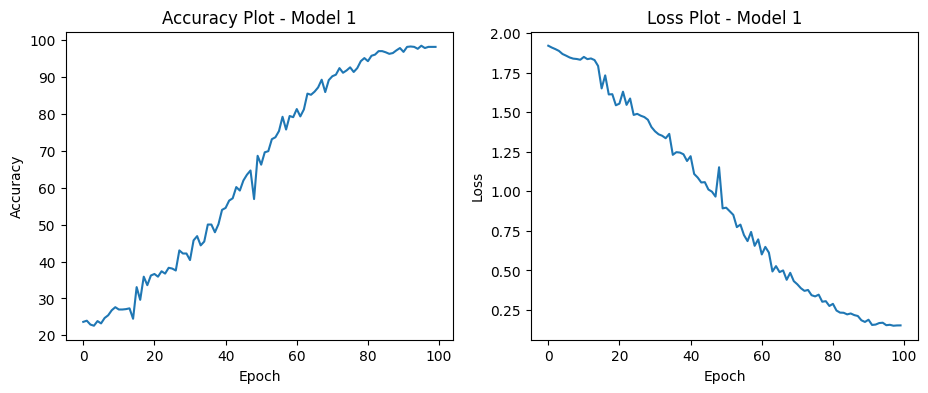

In [71]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(val_acc)
plt.title('Accuracy Plot - Model 1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(122)
plt.plot(val_loss)
plt.title('Loss Plot - Model 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

#### Model 2

In [76]:
val_acc_2 = []
val_loss_2 = []

for epoch in range(0, num_epochs):
    train(net, trainloader, optimizer, scheduler, criterion, epoch, device)
    best_acc = validation(net, valloader, criterion, epoch, device, results_txt, model_name, val_acc_2, val_loss_2)

Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.17it/s]


Epoch: [1]  loss: [2.08] Accuracy [21.79] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.32it/s]



Validation Epoch #1			Loss: 1.8867 Acc@1: 24.50%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.39it/s]


Epoch: [2]  loss: [1.88] Accuracy [24.51] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.74it/s]



Validation Epoch #2			Loss: 1.8826 Acc@1: 28.38%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:07<00:00,  4.46it/s]


Epoch: [3]  loss: [1.85] Accuracy [25.40] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]



Validation Epoch #3			Loss: 1.8861 Acc@1: 26.28%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:06<00:00,  4.48it/s]


Epoch: [4]  loss: [1.84] Accuracy [25.93] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.16it/s]



Validation Epoch #4			Loss: 1.8642 Acc@1: 26.28%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:07<00:00,  4.41it/s]


Epoch: [5]  loss: [1.82] Accuracy [26.74] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.68it/s]



Validation Epoch #5			Loss: 1.8551 Acc@1: 26.28%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.21it/s]


Epoch: [6]  loss: [1.80] Accuracy [27.00] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.43it/s]



Validation Epoch #6			Loss: 1.8401 Acc@1: 26.70%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.19it/s]


Epoch: [7]  loss: [1.78] Accuracy [28.19] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.62it/s]



Validation Epoch #7			Loss: 1.8197 Acc@1: 29.63%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:12<00:00,  4.15it/s]


Epoch: [8]  loss: [1.74] Accuracy [29.29] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.25it/s]



Validation Epoch #8			Loss: 1.7726 Acc@1: 34.35%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:03<00:00,  4.68it/s]


Epoch: [9]  loss: [1.69] Accuracy [31.81] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.40it/s]



Validation Epoch #9			Loss: 1.7454 Acc@1: 35.39%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:04<00:00,  4.64it/s]


Epoch: [10]  loss: [1.65] Accuracy [33.69] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.71it/s]



Validation Epoch #10			Loss: 1.6444 Acc@1: 40.31%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:05<00:00,  4.60it/s]


Epoch: [11]  loss: [1.58] Accuracy [37.28] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.37it/s]



Validation Epoch #11			Loss: 1.5469 Acc@1: 42.30%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:06<00:00,  4.52it/s]


Epoch: [12]  loss: [1.51] Accuracy [38.91] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.70it/s]



Validation Epoch #12			Loss: 1.5134 Acc@1: 44.61%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.37it/s]


Epoch: [13]  loss: [1.47] Accuracy [40.39] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.53it/s]



Validation Epoch #13			Loss: 1.4421 Acc@1: 45.97%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:07<00:00,  4.43it/s]


Epoch: [14]  loss: [1.44] Accuracy [41.61] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.79it/s]



Validation Epoch #14			Loss: 1.3562 Acc@1: 47.33%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:10<00:00,  4.24it/s]


Epoch: [15]  loss: [1.41] Accuracy [42.39] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.66it/s]



Validation Epoch #15			Loss: 1.3656 Acc@1: 46.28%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:09<00:00,  4.28it/s]


Epoch: [16]  loss: [1.38] Accuracy [43.51] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.33it/s]



Validation Epoch #16			Loss: 1.2898 Acc@1: 51.62%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.38it/s]


Epoch: [17]  loss: [1.34] Accuracy [44.64] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.89it/s]



Validation Epoch #17			Loss: 1.2820 Acc@1: 52.15%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.20it/s]


Epoch: [18]  loss: [1.33] Accuracy [44.57] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.84it/s]



Validation Epoch #18			Loss: 1.1789 Acc@1: 55.39%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.18it/s]


Epoch: [19]  loss: [1.29] Accuracy [45.94] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.10it/s]



Validation Epoch #19			Loss: 1.1538 Acc@1: 59.48%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:07<00:00,  4.46it/s]


Epoch: [20]  loss: [1.25] Accuracy [48.42] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.72it/s]



Validation Epoch #20			Loss: 1.1119 Acc@1: 58.22%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:05<00:00,  4.55it/s]


Epoch: [21]  loss: [1.23] Accuracy [49.16] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.52it/s]



Validation Epoch #21			Loss: 1.1156 Acc@1: 55.71%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.39it/s]


Epoch: [22]  loss: [1.22] Accuracy [50.66] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.25it/s]



Validation Epoch #22			Loss: 1.0400 Acc@1: 58.01%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:09<00:00,  4.32it/s]


Epoch: [23]  loss: [1.18] Accuracy [51.47] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.25it/s]



Validation Epoch #23			Loss: 0.9955 Acc@1: 61.05%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:09<00:00,  4.31it/s]


Epoch: [24]  loss: [1.19] Accuracy [51.38] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.46it/s]



Validation Epoch #24			Loss: 1.0137 Acc@1: 60.94%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:09<00:00,  4.28it/s]


Epoch: [25]  loss: [1.15] Accuracy [52.14] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.03it/s]



Validation Epoch #25			Loss: 1.0607 Acc@1: 60.00%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:07<00:00,  4.41it/s]


Epoch: [26]  loss: [1.14] Accuracy [52.97] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.79it/s]



Validation Epoch #26			Loss: 0.9663 Acc@1: 64.40%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:17<00:00,  3.88it/s]


Epoch: [27]  loss: [1.13] Accuracy [53.82] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.31it/s]



Validation Epoch #27			Loss: 0.9397 Acc@1: 65.55%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:24<00:00,  3.53it/s]


Epoch: [28]  loss: [1.11] Accuracy [54.44] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.80it/s]



Validation Epoch #28			Loss: 0.9481 Acc@1: 64.71%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.18it/s]


Epoch: [29]  loss: [1.09] Accuracy [55.98] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.21it/s]



Validation Epoch #29			Loss: 0.9201 Acc@1: 64.82%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.20it/s]


Epoch: [30]  loss: [1.09] Accuracy [55.13] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.87it/s]



Validation Epoch #30			Loss: 0.9236 Acc@1: 68.06%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:10<00:00,  4.26it/s]


Epoch: [31]  loss: [1.07] Accuracy [55.50] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.36it/s]



Validation Epoch #31			Loss: 0.8774 Acc@1: 65.13%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:10<00:00,  4.23it/s]


Epoch: [32]  loss: [1.06] Accuracy [55.87] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.49it/s]



Validation Epoch #32			Loss: 0.7718 Acc@1: 70.99%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:13<00:00,  4.05it/s]


Epoch: [33]  loss: [1.03] Accuracy [57.98] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.64it/s]



Validation Epoch #33			Loss: 0.8538 Acc@1: 70.05%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:12<00:00,  4.13it/s]


Epoch: [34]  loss: [1.02] Accuracy [58.60] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.72it/s]



Validation Epoch #34			Loss: 0.8130 Acc@1: 71.20%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.15it/s]


Epoch: [35]  loss: [1.00] Accuracy [59.04] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.89it/s]



Validation Epoch #35			Loss: 0.7336 Acc@1: 74.14%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:22<00:00,  3.63it/s]


Epoch: [36]  loss: [0.98] Accuracy [60.01] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.76it/s]



Validation Epoch #36			Loss: 0.7444 Acc@1: 70.68%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:17<00:00,  3.85it/s]


Epoch: [37]  loss: [0.98] Accuracy [60.28] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.89it/s]



Validation Epoch #37			Loss: 0.7479 Acc@1: 73.19%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:14<00:00,  4.04it/s]


Epoch: [38]  loss: [0.95] Accuracy [61.08] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.44it/s]



Validation Epoch #38			Loss: 0.7453 Acc@1: 73.40%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:06<00:00,  4.52it/s]


Epoch: [39]  loss: [0.95] Accuracy [61.85] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.49it/s]



Validation Epoch #39			Loss: 0.7457 Acc@1: 73.30%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.34it/s]


Epoch: [40]  loss: [0.91] Accuracy [63.93] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.89it/s]



Validation Epoch #40			Loss: 0.6892 Acc@1: 76.75%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:10<00:00,  4.23it/s]


Epoch: [41]  loss: [0.89] Accuracy [63.27] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.15it/s]



Validation Epoch #41			Loss: 0.6065 Acc@1: 79.48%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:10<00:00,  4.23it/s]


Epoch: [42]  loss: [0.88] Accuracy [65.44] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.63it/s]



Validation Epoch #42			Loss: 0.6347 Acc@1: 77.17%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:10<00:00,  4.22it/s]


Epoch: [43]  loss: [0.87] Accuracy [65.17] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.01it/s]



Validation Epoch #43			Loss: 0.6119 Acc@1: 78.85%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.17it/s]


Epoch: [44]  loss: [0.86] Accuracy [65.75] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.49it/s]



Validation Epoch #44			Loss: 0.6013 Acc@1: 81.15%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:13<00:00,  4.04it/s]


Epoch: [45]  loss: [0.83] Accuracy [66.67] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.28it/s]



Validation Epoch #45			Loss: 0.5533 Acc@1: 82.72%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.17it/s]


Epoch: [46]  loss: [0.83] Accuracy [67.56] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.78it/s]



Validation Epoch #46			Loss: 0.5399 Acc@1: 82.41%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:17<00:00,  3.85it/s]


Epoch: [47]  loss: [0.81] Accuracy [68.46] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]



Validation Epoch #47			Loss: 0.4981 Acc@1: 84.08%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:16<00:00,  3.93it/s]


Epoch: [48]  loss: [0.79] Accuracy [68.41] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.09it/s]



Validation Epoch #48			Loss: 0.5479 Acc@1: 81.88%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:12<00:00,  4.13it/s]


Epoch: [49]  loss: [0.78] Accuracy [68.85] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.22it/s]



Validation Epoch #49			Loss: 0.4864 Acc@1: 84.71%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:20<00:00,  3.73it/s]


Epoch: [50]  loss: [0.78] Accuracy [69.99] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.90it/s]



Validation Epoch #50			Loss: 0.5315 Acc@1: 83.87%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:19<00:00,  3.75it/s]


Epoch: [51]  loss: [0.74] Accuracy [70.89] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.68it/s]



Validation Epoch #51			Loss: 0.5091 Acc@1: 83.87%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:10<00:00,  4.23it/s]


Epoch: [52]  loss: [0.74] Accuracy [70.98] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.21it/s]



Validation Epoch #52			Loss: 0.4526 Acc@1: 86.81%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.35it/s]


Epoch: [53]  loss: [0.73] Accuracy [72.01] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.85it/s]



Validation Epoch #53			Loss: 0.4750 Acc@1: 85.86%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:19<00:00,  3.74it/s]


Epoch: [54]  loss: [0.72] Accuracy [71.70] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.26it/s]



Validation Epoch #54			Loss: 0.4752 Acc@1: 85.03%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:21<00:00,  3.67it/s]


Epoch: [55]  loss: [0.70] Accuracy [72.52] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.47it/s]



Validation Epoch #55			Loss: 0.4234 Acc@1: 88.27%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.19it/s]


Epoch: [56]  loss: [0.70] Accuracy [72.99] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.10it/s]



Validation Epoch #56			Loss: 0.4398 Acc@1: 87.64%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:10<00:00,  4.27it/s]


Epoch: [57]  loss: [0.69] Accuracy [73.25] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.78it/s]



Validation Epoch #57			Loss: 0.3717 Acc@1: 88.69%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.37it/s]


Epoch: [58]  loss: [0.66] Accuracy [74.41] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.81it/s]



Validation Epoch #58			Loss: 0.4172 Acc@1: 87.85%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.15it/s]


Epoch: [59]  loss: [0.67] Accuracy [74.25] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.67it/s]



Validation Epoch #59			Loss: 0.3952 Acc@1: 87.96%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.34it/s]


Epoch: [60]  loss: [0.65] Accuracy [75.15] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.02it/s]



Validation Epoch #60			Loss: 0.3691 Acc@1: 89.84%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.38it/s]


Epoch: [61]  loss: [0.63] Accuracy [75.72] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.59it/s]



Validation Epoch #61			Loss: 0.4011 Acc@1: 89.53%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:10<00:00,  4.26it/s]


Epoch: [62]  loss: [0.63] Accuracy [75.72] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.95it/s]



Validation Epoch #62			Loss: 0.3445 Acc@1: 91.94%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.37it/s]


Epoch: [63]  loss: [0.62] Accuracy [76.66] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.70it/s]



Validation Epoch #63			Loss: 0.3241 Acc@1: 91.73%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:05<00:00,  4.54it/s]


Epoch: [64]  loss: [0.61] Accuracy [76.92] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]



Validation Epoch #64			Loss: 0.3266 Acc@1: 92.36%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.38it/s]


Epoch: [65]  loss: [0.59] Accuracy [77.44] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.78it/s]



Validation Epoch #65			Loss: 0.3027 Acc@1: 92.77%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:12<00:00,  4.11it/s]


Epoch: [66]  loss: [0.60] Accuracy [76.80] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.65it/s]



Validation Epoch #66			Loss: 0.3119 Acc@1: 92.88%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.34it/s]


Epoch: [67]  loss: [0.57] Accuracy [77.79] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.41it/s]



Validation Epoch #67			Loss: 0.3025 Acc@1: 93.30%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:15<00:00,  3.97it/s]


Epoch: [68]  loss: [0.57] Accuracy [78.32] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.72it/s]



Validation Epoch #68			Loss: 0.2971 Acc@1: 93.40%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:12<00:00,  4.11it/s]


Epoch: [69]  loss: [0.55] Accuracy [79.07] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.85it/s]



Validation Epoch #69			Loss: 0.2754 Acc@1: 93.51%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:16<00:00,  3.90it/s]


Epoch: [70]  loss: [0.56] Accuracy [78.78] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.14it/s]



Validation Epoch #70			Loss: 0.2789 Acc@1: 91.20%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:24<00:00,  3.55it/s]


Epoch: [71]  loss: [0.54] Accuracy [79.10] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.48it/s]



Validation Epoch #71			Loss: 0.2785 Acc@1: 92.36%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:14<00:00,  4.02it/s]


Epoch: [72]  loss: [0.53] Accuracy [79.68] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.05it/s]



Validation Epoch #72			Loss: 0.2509 Acc@1: 93.30%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:05<00:00,  4.56it/s]


Epoch: [73]  loss: [0.52] Accuracy [80.82] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.90it/s]



Validation Epoch #73			Loss: 0.2486 Acc@1: 95.29%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.34it/s]


Epoch: [74]  loss: [0.52] Accuracy [80.72] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.77it/s]



Validation Epoch #74			Loss: 0.2425 Acc@1: 95.60%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:05<00:00,  4.57it/s]


Epoch: [75]  loss: [0.52] Accuracy [80.58] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.83it/s]



Validation Epoch #75			Loss: 0.2268 Acc@1: 94.35%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:07<00:00,  4.45it/s]


Epoch: [76]  loss: [0.49] Accuracy [81.77] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.49it/s]



Validation Epoch #76			Loss: 0.2239 Acc@1: 94.14%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:04<00:00,  4.61it/s]


Epoch: [77]  loss: [0.49] Accuracy [81.96] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.81it/s]



Validation Epoch #77			Loss: 0.2153 Acc@1: 95.29%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.37it/s]


Epoch: [78]  loss: [0.49] Accuracy [82.05] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.17it/s]



Validation Epoch #78			Loss: 0.2165 Acc@1: 95.39%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:09<00:00,  4.30it/s]


Epoch: [79]  loss: [0.46] Accuracy [82.63] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.43it/s]



Validation Epoch #79			Loss: 0.2190 Acc@1: 94.14%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.37it/s]


Epoch: [80]  loss: [0.47] Accuracy [81.93] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.54it/s]



Validation Epoch #80			Loss: 0.1921 Acc@1: 95.60%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.20it/s]


Epoch: [81]  loss: [0.47] Accuracy [82.77] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.50it/s]



Validation Epoch #81			Loss: 0.2014 Acc@1: 95.71%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:06<00:00,  4.48it/s]


Epoch: [82]  loss: [0.45] Accuracy [83.14] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.54it/s]



Validation Epoch #82			Loss: 0.1968 Acc@1: 95.60%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.34it/s]


Epoch: [83]  loss: [0.44] Accuracy [83.53] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.52it/s]



Validation Epoch #83			Loss: 0.1870 Acc@1: 96.44%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:07<00:00,  4.46it/s]


Epoch: [84]  loss: [0.44] Accuracy [83.55] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.68it/s]



Validation Epoch #84			Loss: 0.1850 Acc@1: 95.92%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:04<00:00,  4.64it/s]


Epoch: [85]  loss: [0.43] Accuracy [83.76] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.46it/s]



Validation Epoch #85			Loss: 0.1841 Acc@1: 96.65%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:05<00:00,  4.53it/s]


Epoch: [86]  loss: [0.44] Accuracy [84.00] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.30it/s]



Validation Epoch #86			Loss: 0.1771 Acc@1: 96.96%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:04<00:00,  4.63it/s]


Epoch: [87]  loss: [0.43] Accuracy [84.10] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.65it/s]



Validation Epoch #87			Loss: 0.1722 Acc@1: 97.07%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:09<00:00,  4.33it/s]


Epoch: [88]  loss: [0.43] Accuracy [84.06] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.39it/s]



Validation Epoch #88			Loss: 0.1698 Acc@1: 96.65%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:14<00:00,  4.02it/s]


Epoch: [89]  loss: [0.41] Accuracy [84.83] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.07it/s]



Validation Epoch #89			Loss: 0.1687 Acc@1: 96.54%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:09<00:00,  4.30it/s]


Epoch: [90]  loss: [0.41] Accuracy [84.95] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.51it/s]



Validation Epoch #90			Loss: 0.1620 Acc@1: 97.07%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:05<00:00,  4.53it/s]


Epoch: [91]  loss: [0.41] Accuracy [85.17] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.58it/s]



Validation Epoch #91			Loss: 0.1586 Acc@1: 97.49%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:07<00:00,  4.46it/s]


Epoch: [92]  loss: [0.39] Accuracy [85.88] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.62it/s]



Validation Epoch #92			Loss: 0.1515 Acc@1: 97.38%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:06<00:00,  4.48it/s]


Epoch: [93]  loss: [0.41] Accuracy [85.05] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.65it/s]



Validation Epoch #93			Loss: 0.1523 Acc@1: 97.70%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:07<00:00,  4.44it/s]


Epoch: [94]  loss: [0.40] Accuracy [85.52] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.85it/s]



Validation Epoch #94			Loss: 0.1523 Acc@1: 97.38%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:12<00:00,  4.13it/s]


Epoch: [95]  loss: [0.38] Accuracy [86.31] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.82it/s]



Validation Epoch #95			Loss: 0.1461 Acc@1: 98.01%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:18<00:00,  3.80it/s]


Epoch: [96]  loss: [0.38] Accuracy [85.95] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.86it/s]



Validation Epoch #96			Loss: 0.1443 Acc@1: 97.59%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:14<00:00,  4.01it/s]


Epoch: [97]  loss: [0.37] Accuracy [86.45] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.70it/s]



Validation Epoch #97			Loss: 0.1362 Acc@1: 97.91%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:07<00:00,  4.43it/s]


Epoch: [98]  loss: [0.38] Accuracy [86.23] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.53it/s]



Validation Epoch #98			Loss: 0.1387 Acc@1: 97.38%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:11<00:00,  4.18it/s]


Epoch: [99]  loss: [0.38] Accuracy [86.11] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.83it/s]



Validation Epoch #99			Loss: 0.1377 Acc@1: 97.59%
Training


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:08<00:00,  4.35it/s]


Epoch: [100]  loss: [0.36] Accuracy [87.10] 
validation


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.03it/s]


Validation Epoch #100			Loss: 0.1374 Acc@1: 98.01%


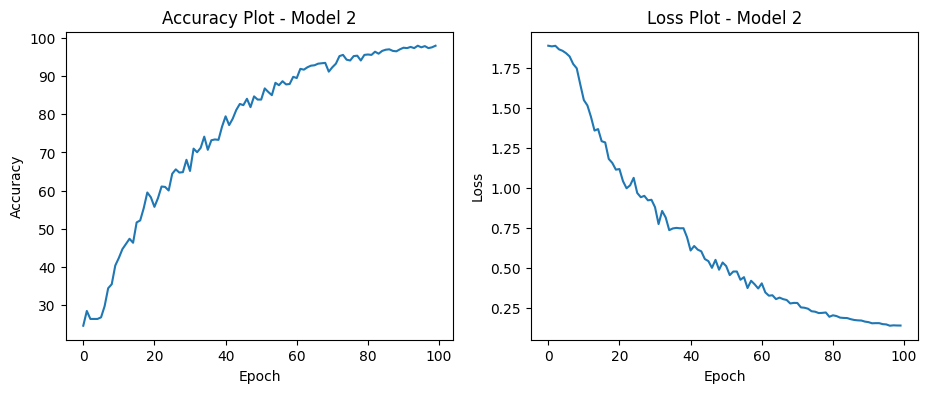

In [78]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(val_acc_2)
plt.title('Accuracy Plot - Model 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(122)
plt.plot(val_loss_2)
plt.title('Loss Plot - Model 2')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

#### Model 3

In [85]:
val_acc_3 = []
val_loss_3 = []

for epoch in range(0, num_epochs):
    train(net, trainloader, optimizer, scheduler, criterion, epoch, device)
    best_acc = validation(net, valloader, criterion, epoch, device, results_txt, model_name, val_acc_3, val_loss_3)

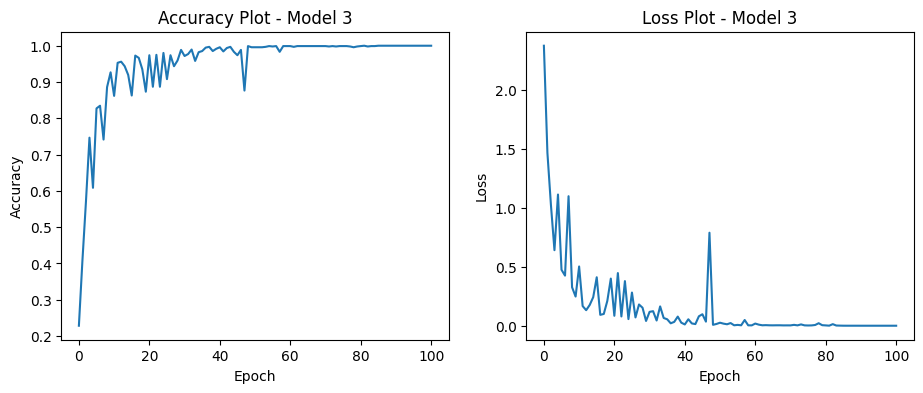

In [86]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(val_acc_3)
plt.title('Accuracy Plot - Model 3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(122)
plt.plot(val_loss_3)
plt.title('Loss Plot - Model 3')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()